**參考資料**


*   https://keras.io/examples/nlp/pretrained_word_embeddings/
*   https://nlp.stanford.edu/projects/glove/



In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-12-03 16:15:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-03 16:15:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-03 16:15:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, CuDNNLSTM, GlobalMaxPooling1D, Embedding, Bidirectional, TimeDistributed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10000)


# Load Dataset

In [3]:
df = pd.read_csv("yelp.csv")
df = df.loc[:, ['stars', 'text']] # 資料保留
df.loc[(df['stars'] <  4), 'stars'] = 0 # map 小於 4 to 0
df.loc[(df['stars'] >=  4), 'stars'] = 1 # map 大於等於 4 to 1


# Word embedding

In [4]:
text_ds = tf.data.Dataset.from_tensor_slices(df['text']).batch(128) # 切割原始資分段切割，建立dataset
# list(text_ds.as_numpy_iterator()) # 看轉換後內容

In [5]:
vectorizer = TextVectorization(max_tokens=25000, output_sequence_length=300) # 設定vectorizer，建立25000個token，輸出為300為的矩陣
vectorizer.adapt(text_ds)
# print(df['text'][1])
# vectorizer([df['text'][1]]).numpy()

In [6]:
voc = vectorizer.get_vocabulary() # 建立起來的text list
word_index = dict(zip(voc, range(len(voc)))) # 建立text dictionary
print(word_index)


{'': 0, '[UNK]': 1, 'the': 2, 'and': 3, 'i': 4, 'a': 5, 'to': 6, 'of': 7, 'was': 8, 'is': 9, 'it': 10, 'for': 11, 'in': 12, 'that': 13, 'my': 14, 'with': 15, 'but': 16, 'this': 17, 'you': 18, 'they': 19, 'on': 20, 'we': 21, 'have': 22, 'not': 23, 'had': 24, 'are': 25, 'good': 26, 'place': 27, 'so': 28, 'at': 29, 'were': 30, 'food': 31, 'as': 32, 'be': 33, 'there': 34, 'great': 35, 'like': 36, 'if': 37, 'its': 38, 'me': 39, 'all': 40, 'just': 41, 'out': 42, 'very': 43, 'here': 44, 'one': 45, 'their': 46, 'or': 47, 'get': 48, 'from': 49, 'when': 50, 'up': 51, 'time': 52, 'go': 53, 'really': 54, 'our': 55, 'about': 56, 'some': 57, 'service': 58, 'would': 59, 'an': 60, 'what': 61, 'been': 62, 'can': 63, 'which': 64, 'your': 65, 'back': 66, 'more': 67, 'dont': 68, 'only': 69, 'will': 70, 'also': 71, 'by': 72, 'no': 73, 'too': 74, 'im': 75, 'love': 76, 'little': 77, 'has': 78, 'nice': 79, 'well': 80, 'other': 81, 'ive': 82, 'because': 83, 'them': 84, 'always': 85, 'do': 86, 'even': 87, 'than

In [7]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [8]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19688 words (5312 misses)


# Training and testing data spilt

In [9]:
x_train = vectorizer(np.array([[s] for s in df['text'][:8000]])).numpy()
y_train = np.array(df['stars'][:8000]).reshape(8000, 1)
x_test = vectorizer(np.array([[s] for s in df['text'][8000:]])).numpy()
y_test = np.array(df['stars'][8000:]).reshape(2000, 1)

# Plot training history

In [10]:
def plot_history(history):
  plt.tight_layout()
  plt.plot(history.history['acc'], 'g-o')
  plt.plot(history.history['val_acc'], 'r-o')
  plt.title('train & val acc')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_acc', 'val_acc'], loc='upper left')
  plt.show()


  plt.plot(history.history['loss'], 'g-o')
  plt.plot(history.history['val_loss'], 'r-o')
  plt.title('train & val loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'], loc='upper left')
  plt.show()

# Build CNN Model

Epoch 1/20
128/128 [==============================] - 10s 18ms/step - loss: 0.6753 - acc: 0.6483 - val_loss: 0.6331 - val_acc: 0.6825
Epoch 2/20
128/128 [==============================] - 2s 17ms/step - loss: 0.5684 - acc: 0.7066 - val_loss: 0.6144 - val_acc: 0.7319
Epoch 3/20
128/128 [==============================] - 2s 17ms/step - loss: 0.5110 - acc: 0.7484 - val_loss: 0.5352 - val_acc: 0.7800
Epoch 4/20
128/128 [==============================] - 2s 17ms/step - loss: 0.4699 - acc: 0.7827 - val_loss: 0.5305 - val_acc: 0.7719
Epoch 5/20
128/128 [==============================] - 2s 17ms/step - loss: 0.4472 - acc: 0.7934 - val_loss: 0.5276 - val_acc: 0.7594
Epoch 6/20
128/128 [==============================] - 2s 17ms/step - loss: 0.4305 - acc: 0.8031 - val_loss: 0.5027 - val_acc: 0.8119
Epoch 7/20
128/128 [==============================] - 2s 18ms/step - loss: 0.4061 - acc: 0.8119 - val_loss: 0.4657 - val_acc: 0.8231
Epoch 8/20
128/128 [==============================] - 2s 17ms/step -

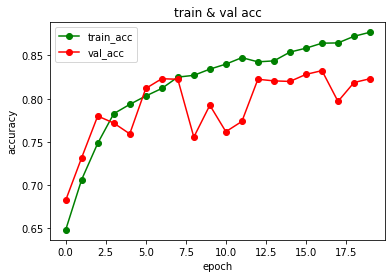

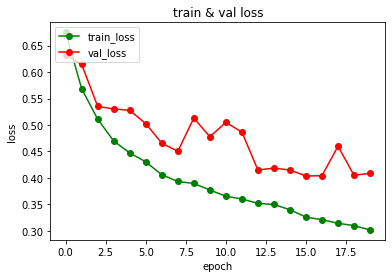

In [20]:
model = Sequential()
model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False))
model.add(Conv1D(64, 3, padding='causal'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 3, padding='causal'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=0.0005), metrics=['acc'])
history = model.fit(x_train, y_train, epochs = 20, batch_size = 50, use_multiprocessing=True, validation_split=0.2)
model.evaluate(x_test, y_test, batch_size = 100)
plot_history(history)

In [21]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 300)         7500600   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          57664     
                                                                 
 dropout_26 (Dropout)        (None, None, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          12352     
                                                                 
 dropout_27 (Dropout)        (None, None, 64)          0         
                                                      

# Build LSTM model

Epoch 1/20
128/128 [==============================] - 177s 407ms/step - loss: 0.6164 - acc: 0.6849 - val_loss: 0.6487 - val_acc: 0.6873
Epoch 2/20
128/128 [==============================] - 50s 388ms/step - loss: 0.6170 - acc: 0.6841 - val_loss: 0.6145 - val_acc: 0.6744
Epoch 3/20
128/128 [==============================] - 50s 387ms/step - loss: 0.6001 - acc: 0.6894 - val_loss: 0.6245 - val_acc: 0.6744
Epoch 4/20
128/128 [==============================] - 51s 400ms/step - loss: 0.6029 - acc: 0.6928 - val_loss: 0.5920 - val_acc: 0.6876
Epoch 5/20
128/128 [==============================] - 51s 403ms/step - loss: 0.5612 - acc: 0.7132 - val_loss: 0.6244 - val_acc: 0.6744
Epoch 6/20
128/128 [==============================] - 52s 403ms/step - loss: 0.6193 - acc: 0.6863 - val_loss: 0.6193 - val_acc: 0.6744
Epoch 7/20
128/128 [==============================] - 50s 388ms/step - loss: 0.5763 - acc: 0.6933 - val_loss: 0.5900 - val_acc: 0.7017
Epoch 8/20
128/128 [==============================] - 

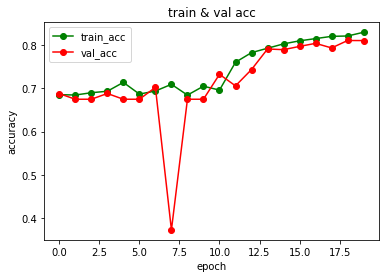

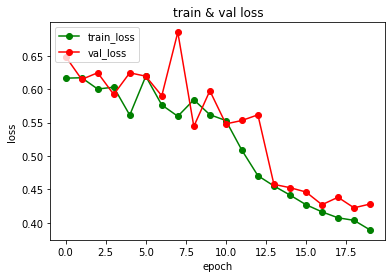

In [18]:
model = Sequential()
model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add((Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=0.0005), metrics=['acc'])
history = model.fit(x_train, y_train, epochs = 20, batch_size = 50, use_multiprocessing=True, validation_split=0.2)
model.evaluate(x_test, y_test, batch_size = 100)
plot_history(history)


In [19]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         7500600   
                                                                 
 cu_dnnlstm_17 (CuDNNLSTM)   (None, None, 200)         401600    
                                                                 
 dropout_22 (Dropout)        (None, None, 200)         0         
                                                                 
 cu_dnnlstm_18 (CuDNNLSTM)   (None, None, 200)         321600    
                                                                 
 dropout_23 (Dropout)        (None, None, 200)         0         
                                                                 
 cu_dnnlstm_19 (CuDNNLSTM)   (None, None, 200)         321600    
                                                                 
 dropout_24 (Dropout)        (None, None, 200)        